In [148]:
import tensorflow as tf
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import random
import sklearn.linear_model

In [175]:
class Dataset:
    
    def __init__(self, label_directory, data_directory, truth_directory, validation_directory, scale=4, seed_num=60):
        self.data_directory = data_directory
        self.label_directory = label_directory
        self.truth_directory = truth_directory
        self.valid_directory = validation_directory
        self.scale = scale
        random.seed(seed_num)
        self.image_list = []
    
    def generateInputData(self):
        self.image_list = []
        for file in listdir(self.label_directory):
            image = Image.open(join(self.label_directory,file))
            image = image.resize(size=(int(image.width/self.scale),int(image.height/self.scale)),resample=Image.LANCZOS)
            image.save(join(self.data_directory,file))
            image = image.resize(size=(image.width*self.scale,image.height*self.scale),resample=Image.BICUBIC)
            image.save(join(self.truth_directory,file))
            self.image_list.append(file)
            image.close()
    
    def initializeImageList(self):
        self.image_list = []
        for file in listdir(self.label_directory):
            self.image_list.append(file)
            
    def getValidation(self,batch_size):
        
        dataArray = np.zeros(dtype=np.float32,shape=(batch_size,50,50,3))
        labelArray = np.zeros(dtype=np.float32,shape=(batch_size,200,200,3))
        truthArray = np.zeros(dtype=np.float32,shape=(batch_size,200,200,3))
        
        counter = 0
        
        for file in listdir(self.valid_directory):
            if(counter == batch_size):
                break
            label = Image.open(join(self.valid_directory,file))
            label.load()
            labelArray[counter] = np.asarray(label,dtype=np.float32)/255.0
            label = label.resize(size=(int(label.width/self.scale),int(label.height/self.scale)),resample=Image.LANCZOS)
            label.load()
            dataArray[counter] = np.asarray(label,dtype=np.float32)/255.0
            label = label.resize(size=(label.width*self.scale,label.height*self.scale),resample=Image.BICUBIC)
            label.load()
            truthArray[counter] = np.asarray(label,dtype=np.float32)/255.0
            label.close()
            counter += 1
            
        return (dataArray,labelArray,truthArray)
        
    def getRandomImage(self):
        random_num = random.randint(0,len(self.image_list)-1)
        data = Image.open(join(self.data_directory,self.image_list[random_num]))
        data.load()
        label = Image.open(join(self.label_directory,self.image_list[random_num]))
        label.load()
        truth = Image.open(join(self.truth_directory,self.image_list[random_num]))
        truth.load()
        
        data_array = np.asarray(data,dtype=np.float32)/255.0
        label_array = np.asarray(label,dtype=np.float32)/255.0
        truth_array = np.asarray(truth,dtype=np.float32)/255.0
        
        data.close()
        label.close()
        truth.close()
        
        return (data_array,label_array,truth_array)
        

In [211]:
class NetworkModel:
    
    def __init__(self, save_directory,batch_size):
        self.save_directory = save_directory
        self.batch_size = batch_size
        
        self.buildNetwork()
        
        self.session = tf.Session()
        
        init = tf.global_variables_initializer()
        self.session.run(init)
        
        self.saver = tf.train.Saver(var_list=tf.trainable_variables())
    
    def buildNetwork(self):
        self.input = tf.placeholder(name="input",dtype=tf.float32,shape=[self.batch_size,None,None,3])
        self.label = tf.placeholder(name="label",dtype=tf.float32,shape=[self.batch_size,None,None,3])
        self.truth = tf.placeholder(name="truth",dtype=tf.float32,shape=[self.batch_size,None,None,3])
        
        self.truth_loss = tf.losses.mean_squared_error(labels=self.label,predictions=self.truth)
        
        self.learning_rate_ph = tf.placeholder(tf.float32, shape=[])
        
        #feature extraction layers
        conv1 = self.addConv(input_layer = self.input, filter_num = 512)
        batch_conv1 = tf.keras.layers.BatchNormalization()(conv1)
        out_conv1 = self.addLeakyRelu(input_layer = batch_conv1)
        conv2 = self.addConv(input_layer = out_conv1, filter_num = 256)
        batch_conv2 = tf.keras.layers.BatchNormalization()(conv2)
        out_conv2 = self.addLeakyRelu(input_layer = batch_conv2)
        conv3 = self.addConv(input_layer = out_conv2, filter_num = 128)
        batch_conv3 = tf.keras.layers.BatchNormalization()(conv3)
        out_conv3 = self.addLeakyRelu(input_layer = batch_conv3)
        conv4 = self.addConv(input_layer = out_conv3, filter_num = 96)
        batch_conv4 = tf.keras.layers.BatchNormalization()(conv4)
        out_conv4 = self.addLeakyRelu(input_layer = batch_conv4)
        conv5 = self.addConv(input_layer = out_conv4, filter_num = 64)
        batch_conv5 = tf.keras.layers.BatchNormalization()(conv5)
        out_conv5 = self.addLeakyRelu(input_layer = batch_conv5)
        conv6 = self.addConv(input_layer = out_conv5, filter_num = 64)
        batch_conv6 = tf.keras.layers.BatchNormalization()(conv6)
        out_conv6 = self.addLeakyRelu(input_layer = batch_conv6)
        conv7 = self.addConv(input_layer = out_conv6, filter_num = 64)
        batch_conv7 = tf.keras.layers.BatchNormalization()(conv7)
        out_conv7 = self.addLeakyRelu(input_layer = batch_conv7)
        conv8 = self.addConv(input_layer = out_conv7, filter_num = 64)
        batch_conv8 = tf.keras.layers.BatchNormalization()(conv8)
        out_conv8 = self.addLeakyRelu(input_layer = batch_conv8)
        
        #skip connections
        concat = tf.concat([out_conv1,out_conv2,out_conv3,out_conv4,out_conv5,out_conv6,out_conv7,out_conv8],axis=3)
        
        #channel reduction layer/network in network
        feature_reduce = self.addConv(input_layer = concat, filter_num = 96, kernel_size = 1)
        out_feature_reduce = self.addLeakyRelu(input_layer=feature_reduce)
        
        feature_reduce_2 = self.addConv(input_layer = concat, filter_num = 96, kernel_size = 1)
        out_feature_reduce_2 = self.addLeakyRelu(input_layer=feature_reduce_2)
        feature_extract_2 = self.addConv(input_layer = out_feature_reduce_2, filter_num = 72)
        out_feature_extract_2 = self.addLeakyRelu(input_layer = feature_extract_2)
        
        #reconstruction layer
        reconstruct = tf.concat([out_feature_reduce,out_feature_extract_2],axis=3)
        upsample = self.addTransposeConv(input_layer=reconstruct,filter_num=128)
        out_upsample = self.addLeakyRelu(input_layer = upsample)
        upsample_2 = self.addTransposeConv(input_layer = out_upsample, filter_num=96)
        out_upsample_2 = self.addLeakyRelu(input_layer=upsample_2)
        self.output = (self.addConv(input_layer=out_upsample_2,filter_num=3,use_bias=False) + self.truth)
        
        #loss/training
        self.loss = tf.losses.mean_squared_error(labels=self.label,predictions=self.output)
        
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate_ph)
        self.train = self.optimizer.minimize(self.loss)
        
    def addConv(self,input_layer,filter_num,kernel_size=5,padding='SAME',use_bias=True):
        return tf.keras.layers.Conv2D(filters=filter_num,kernel_size=(kernel_size,kernel_size),padding=padding, use_bias = use_bias)(input_layer)
    
    def addPrelu(self,input_layer,alpha_init='zeros',shared_axes=[1,2]):
        return tf.keras.layers.PReLU(alpha_initializer=alpha_init,shared_axes=shared_axes)(input_layer)
    
    def addLeakyRelu(self,input_layer,alpha=0.3):
        return tf.keras.layers.LeakyReLU(alpha=alpha)(input_layer)
    
    def addTransposeConv(self,input_layer,filter_num,kernel_size=5,strides=2,padding='SAME'):
        return tf.keras.layers.Conv2DTranspose(filters=filter_num,kernel_size=(kernel_size,kernel_size),padding=padding, strides=strides, use_bias = True)(input_layer)
    
    def trainData(self, data, label, truth, learning_rate):
        feed_dict = {
          self.input: data,
          self.label: label,
          self.truth: truth,
          self.learning_rate_ph: learning_rate
        }
        
        output,loss,_,truth_loss=self.session.run([self.output,self.loss,self.train,self.truth_loss],feed_dict=feed_dict)
        
        return (loss,truth_loss)
    
    def getOutput(self,data,truth,label):
        feed_dict= {
            self.input: data,
            self.truth: truth,
            self.label: label
        }
        batch_size = self.batch_size
        self.batch_size = 1
        output,loss,truth_loss = self.session.run([self.output,self.loss,self.truth_loss],feed_dict=feed_dict)
        self.batch_size = batch_size
        return (output,loss,truth_loss)
    
    def save(self):
        directory = self.saver.save(self.session, self.save_directory)
        print("saving to " + directory)
    
    def restore(self):
        self.saver.restore(self.session, self.save_directory)
        print("restored variables...")
    
    def close(self):
        self.session.close()

In [212]:
class Training:
    #decrease_learning_rate_datapoints -> num of datapoints to consider when decreasing learning rate
    def __init__(self, learning_rate, batch_size,save_directory,decrease_learning_rate_datapoints=10,loss_print=100,checkpoint=1000):
        self.initial_learning_rate = learning_rate
        self.batch_size = batch_size
        self.save_directory = save_directory
        self.loss_print = loss_print
        self.checkpoint = checkpoint
        
    def startTraining(self, dataset,restore=False):
        self.network = NetworkModel(self.save_directory,self.batch_size)
        
        if(restore):
            self.network.restore()
        
        datapoints = []
        
        counter = 0
        
        valid_batch_data, valid_batch_label, valid_batch_truth = dataset.getValidation(self.batch_size)

        while(True):
            
            batch_data = np.zeros(dtype=np.float32,shape=(self.batch_size,50,50,3))
            batch_label = np.zeros(dtype=np.float32,shape=(self.batch_size,200,200,3))
            batch_truth = np.zeros(dtype=np.float32,shape=(self.batch_size,200,200,3))
            
            for j in range(0,self.batch_size):
                data,label,truth = dataset.getRandomImage()
                batch_data[j] = data
                batch_label[j] = label
                batch_truth[j] = truth
                
            loss,truth_loss = self.network.trainData(batch_data,batch_label,batch_truth,self.initial_learning_rate)
            counter = counter + 1
            
            if(counter % self.loss_print == 0 or counter == 1):
                print("loss at step " + str(counter) + " was: "+str(loss))
                print("loss of truth compared to label was "+str(truth_loss))
                print("loss of truth - loss at this step is: " + str(truth_loss-loss))
                
            if(counter % self.checkpoint == 0):
                self.network.save()
            
        self.network.close()
    
    def getoutput(self,data,truth,label):
        network = NetworkModel(self.save_directory,1)
        network.restore()
        
        (output,loss,truth_loss) = network.getOutput(data,truth,label)

        network.close()
        
        return (output,loss,truth_loss)
    
    def close(self):
        self.network.close()

In [223]:
#initialize dataset here:
dataset = Dataset("C:\\Users\\Steven\\Desktop\\face_label","C:\\Users\\Steven\\Desktop\\face_data","C:\\Users\\Steven\\Desktop\\face_truth","C:\\Users\\Steven\\Desktop\\face_validation")
dataset.initializeImageList()

In [191]:
dataset.generateInputData()

In [224]:
tf.reset_default_graph()
train = Training(0.0005,16,"C:\\Users\\Steven\\Desktop\\model\model.ckpt",checkpoint=1000)

In [ ]:
train.startTraining(dataset,restore=False)

W0920 00:09:40.481608 10308 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


restored variables...
0.0004318252
0.0006336641
(1, 200, 200, 3)


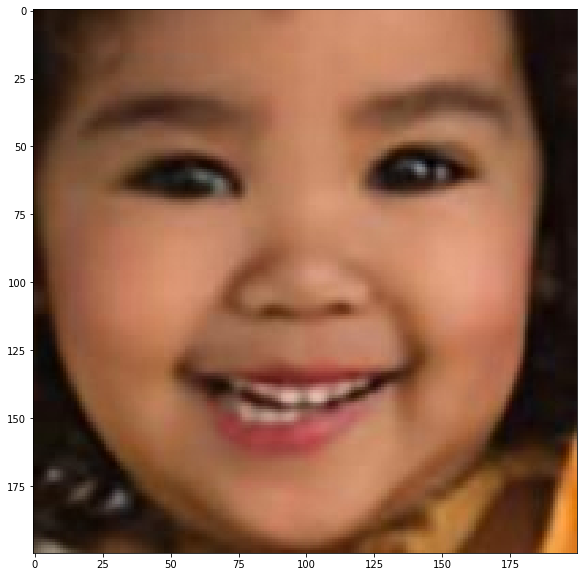

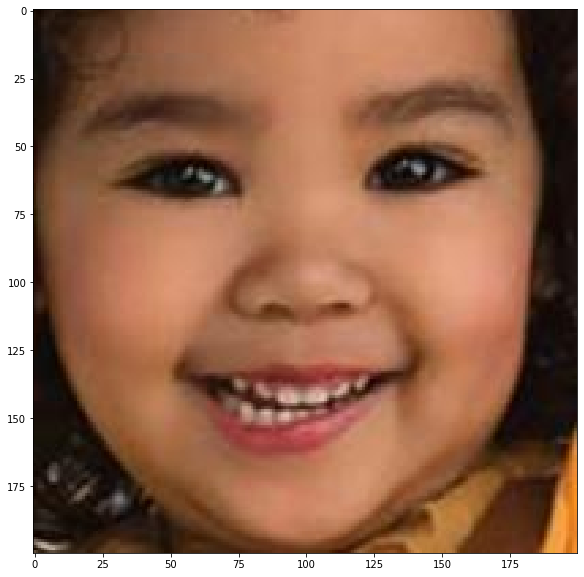

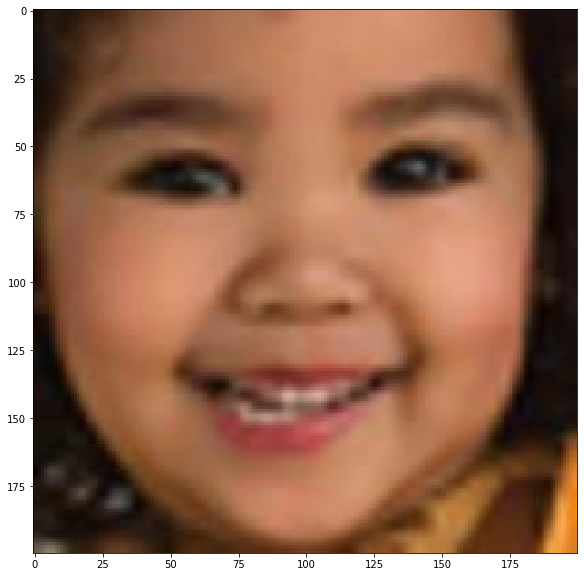

In [199]:
tf.reset_default_graph()
(data,label,truth) = dataset.getRandomImage()
(output,loss,truth_loss) = train.getoutput(np.expand_dims(data,axis=0),np.expand_dims(truth,axis=0),np.expand_dims(label,axis=0))
print(loss)
print(truth_loss)
print(output.shape)
plt.figure(figsize=(10,10))
plt.imshow(output[0,:,:,:])
plt.figure(figsize=(10,10))
plt.imshow(label)
plt.figure(figsize=(10,10))
plt.imshow(truth)

In [187]:
train.close()